Text classification/sentiment analysis of movie reviews following the tutorial from https://www.tensorflow.org/tutorials/keras/text_classification

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# download IMDB dataset
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url, untar=True, cache_dir='.',cache_subdir='')
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84131840/84125825 [==============================] - 13s 0us/step


In [6]:
# list the dataset directory 
os.listdir(dataset_dir)

['imdbEr.txt', 'test', 'imdb.vocab', 'README', 'train']

In [7]:
# directory for training
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_unsup.txt',
 'neg',
 'urls_pos.txt',
 'unsup',
 'urls_neg.txt',
 'pos',
 'unsupBow.feat',
 'labeledBow.feat']

```train_dir/pos``` 
contains
 a list of positive movie reviews, 
```train_dir/neg```
contains a list of negative movie reviews
read a sample positive file to see what is in it

In [ ]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Now we need to prepare the data for binary classification. There should be 2 folders (one for each classification): positive and negative movie reviews. This means that we need to get rid of superflous folders

In [ ]:

remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)


we want to create a tensorflow dataset, so we will use 
```text_dataset_from_directory``` 
to create that dataset. We also need to make sure that the dataset has 3 splits: train, validation, and test.
The IMDB dataset already has train and test but needs a validation split

In [11]:
# 80:20 split of training data to create validation split
batch_size = 32
seed = 42
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


Since we are new to 
```tf.data```
we will interate over the dataset to see what it looks like.


In [12]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

We are going to use the remaining 5000 reviews for the validation set

In [13]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [14]:
# test set
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


we need to standardize the data so that it can be turned into text vectors. Therefore we need to strip punctuation and HTML. 
```preprocessing.TextVectorization```
turns the text into vectors AND strips punctuation. However, it does not strip HTML, and we can see that we have 
```<br/>```
tags

In [28]:
# a function that takes the input data, turns it to lower case, replaces <br/> with a space, and then pops it back into the data and then escapes all potentiall problematic punctuation so that it doesn't read it as a # special character.
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [29]:
max_features = 1000
sequence_length = 250
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

calling 
```adapt```
will fit the preprocessing layer to the data. This will "cause the model to build an index of strings to integers" -- we are unsure as to what they mean here

In [30]:
# Make a text-only dataset (without labels), then call adapt. We train our data against the training dataset, called train_text!
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

We can't see what's happening here, so we create a function to print out the result of this layer.

In [38]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label


In [39]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'"Emma" was a product of what might be called by the First Great Jane Austen Cycle of the mid-nineties, and it was recently shown on British television, doubtless because of the interest in the author created by the Second Great Jane Austen Cycle which started with "Pride and Prejudice" two years ago. We currently have in the cinemas the Austen biopic "Becoming Jane", and ITV have recently produced three TV movies based on Austen novels. These include "Northanger Abbey", the only one of the six major novels not to have been filmed previously, so the cycle should now be complete. No doubt, however, there will be more to come in the near future. (There is, after all, her juvenile "Love and Freindship" (sic), the short novella "Lady Susan", and someone, somewhere, has doubtless supplied endings to her two unfinished fragments "The Watsons" and "Sanditon". Then there are all those Austen sequels churned out by modern writers\xc2\x85\xc2\x85\xc2\x85).<br /><br />The main c

This array is meaningless. each number is JUST AN INDEX, a pointer to the vocabulary. we can find out what the string is by calling
```getVocabulary```
on the layer

In [41]:
print("555 ---> ",vectorize_layer.get_vocabulary()[555])
print("729 ---> ",vectorize_layer.get_vocabulary()[729])
print(" 1 ---> ",vectorize_layer.get_vocabulary()[1])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

555 --->  complete
729 --->  lady
 1 --->  [UNK]
Vocabulary size: 1000


1 is unknown! that makes so much sense!!!

Now we apply the text vectorization to our 3 datasets

In [42]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

We need to optimize for performance because this is a butt ton of data.
we will use 
```.cache()```
which keeps data in memory after its loaded off disk, this is kinda like memoization we think. avoids bottlenecking
we will also use 
```.prefetch()``` which always data preprocessing the model execution to happen as simultaneously as possible (this can happen because it is such a big dataset)


In [43]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Time to create the neural net! 

* We will have 16 embedding dimensions. The embedding layer is the first layer of the neural net. This takes the reviews which have been turned into the int arrays (as printed out above) and looks up an embedding vector for each word index. These vectors start out with randomized weight, but the weights are adjusted through backpropagation as the model trains. This will then return 3 dimensions to the output of the embedding layer: batch, equence, and embedding

*  ```GlobalAveragePooling1D```
is the layer that returns a layer that returns a fixed-length output vector for each input review by averaging over the sequence dimension of the embedding layer of the neural net
* the GlobalAveragePooling1D layer is then piped through a 
```Dense``` layer, which has 15 hidden units. This is written for us! yeee
* the last layer is densely connected with a single output node.

In [44]:
embedding_dim = 16
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          16016     
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 16,033
Trainable params: 16,033
Non-trainable params: 0
_________________________________________________________________


Next we will need a loss function and an optimizer for training. we can import a loss function from tensorflow. Since this is a binary classifier, we can use the 
```BinaryCrossentropy``` loss function
we need to configure the model to use the loss function. apparently we use the optimizer adam?

In [45]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

train the model

In [46]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 11s 18ms/step - loss: 0.6690 - binary_accuracy: 0.6625 - val_loss: 0.6316 - val_binary_accuracy: 0.7334
Epoch 2/10
625/625 [==============================] - 2s 3ms/step - loss: 0.5825 - binary_accuracy: 0.7589 - val_loss: 0.5397 - val_binary_accuracy: 0.7868
Epoch 3/10
625/625 [==============================] - 2s 3ms/step - loss: 0.4997 - binary_accuracy: 0.8022 - val_loss: 0.4717 - val_binary_accuracy: 0.8102
Epoch 4/10
625/625 [==============================] - 2s 3ms/step - loss: 0.4450 - binary_accuracy: 0.8239 - val_loss: 0.4305 - val_binary_accuracy: 0.8226
Epoch 5/10
625/625 [==============================] - 2s 2ms/step - loss: 0.4117 - binary_accuracy: 0.8331 - val_loss: 0.4057 - val_binary_accuracy: 0.8336
Epoch 6/10
625/625 [==============================] - 2s 2ms/step - loss: 0.3909 - binary_accuracy: 0.8403 - val_loss: 0.3900 - val_binary_accuracy: 0.8378
Epoch 7/10
625/625 [==============================] - 2s 3ms/s

based on our validation set, looks like we are at 84.24% accuracy! woohoo. this can also be nicely displayed:


In [47]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 11s 14ms/step - loss: 0.3592 - binary_accuracy: 0.8457
Loss:  0.35923221707344055
Accuracy:  0.8457199931144714


lets plot it! when we called 
```model.fit()```
we got a history object which contains a dictionary of everything that happened during training. we can use this.

In [48]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

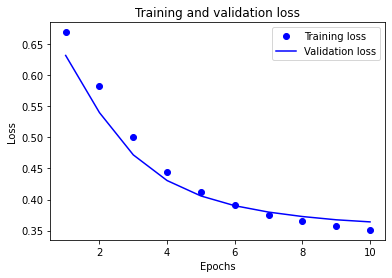

In [49]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

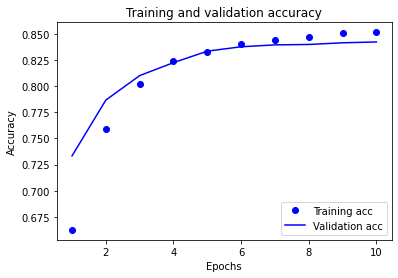

In [50]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

Now we will export our model (really just exporting the weights for the neural net) and test it on a new dataset that we create.

In [53]:
# export the old model's weights
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

# compile it into a new model without training.
export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 12s 15ms/step - loss: 0.3592 - accuracy: 0.8457
0.8457199931144714


now lets write some new data to test the model on

In [57]:
examples = [
  "The movie was thrilling and a non stop laugh!",
  "The movie was boring.",
  "The movie was amazing",
  "this movie was horrible"
]

export_model.predict(examples)

array([[0.5317046 ],
       [0.35874447],
       [0.6589712 ],
       [0.37188673]], dtype=float32)